#+TITLE: Learning Rate Schedules
#+CATEGORIES: optimization
#+DESCRIPTION: These strategies adjust the learning rate, and/or other optimizer parameters, throughout the training process. Generally, large learning rates are used in the early stages of training where large steps can be taken to improve efficiency before slowly decaying to small rates to encourage fine-grained convergence.
#+DATE: 2020-01-02
#+HERO: /static/space-bg.png

# Overview

Learning rate scheduling is a crucial component to training good models.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

plt.style.use('./deadneuron.mplstyle')

Let's start with a simple CNN.

In [2]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, n_outputs=10):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*3*3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
model = LeNet()

Now we'll plot some example learning rate schedules. Pytorch provides several nice functions that plug in directly to an optimizer.

/home/tim/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


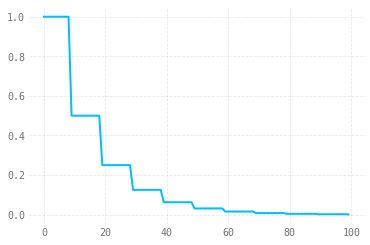

In [3]:
def plot_schedule(scheduler, steps=100):
    scheduler.optimizer.param_groups[0]['lr'] = 1.0

    y = []
    
    for i in range(steps):
        scheduler.step()
        y.append(scheduler.get_last_lr())
    
    plt.plot(range(steps), y)

optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

plot_schedule(scheduler)

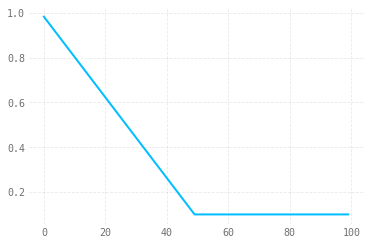

In [4]:
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=50)

plot_schedule(scheduler)

The cosine annealing scheduler tends to be very popular in many contexts for it's smooth decaying property.

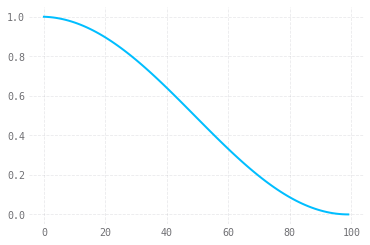

In [5]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

plot_schedule(scheduler)

Several low-cost ensemble learning algorithms make use of cyclic schedules. Snapshot ensembles are the most popular of these.

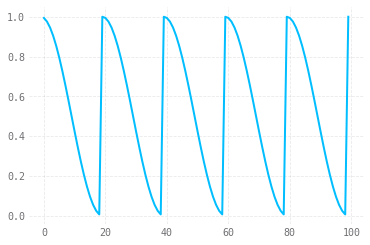

In [6]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

plot_schedule(scheduler)

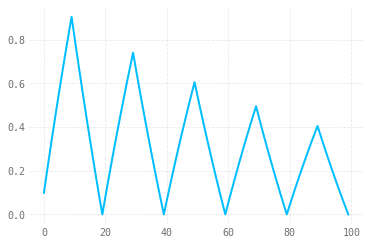

In [7]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0, max_lr=1, step_size_up=10, step_size_down=10, mode="exp_range", gamma=0.99)

plot_schedule(scheduler)

The one cycle schedule is a very effective strategy which includes a warmup phase followed by a decay phase. This has been shown to lead to super-convergence in some cases and is highly effective for tuning subnetworks.

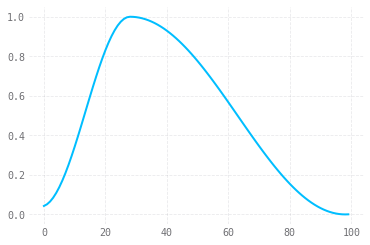

In [8]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.0, total_steps=100)

plot_schedule(scheduler)